In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##T5 Model Training for TST

In [ ]:
#Installing transformer package 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd

In [ ]:
#Loading the standard T5 small model and tokenizer 
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
base_tokenizer = AutoTokenizer.from_pretrained('t5-small')
base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
#Encoding function which will tokenize the input sequence, and create attention mask, tokenized ids, and the labels for model training 
def encode_sequences(x, base_tokenizer = base_tokenizer):
  try:
    x = str(x)
    input = ' '.join(x.split()[:x.split().index('Output:')])
    label = ' '.join(x.split()[x.split().index('Output:'):])
    model_input = base_tokenizer(input, max_length = 512, truncation=True, padding='max_length')
    model_input['labels'] = base_tokenizer(label, max_length = 512, truncation=True, padding='max_length')['input_ids']
    return model_input
  except:
    input = ''
    label = ''
    model_input = base_tokenizer(input, max_length = 512, truncation=True, padding='max_length')
    model_input['labels'] = base_tokenizer(label, max_length = 512, truncation=True, padding='max_length')['input_ids']
    return model_input

In [ ]:
#Change the file location when training using new dataset 
filename = "Taylor"
dataset = pd.read_csv(f'/content/drive/MyDrive/685 Project/{filename}_TST/{filename}_BT_TST.csv')

In [ ]:
dataset = dataset['content'].apply(encode_sequences)

In [ ]:
dataset.head()

0    [input_ids, attention_mask, labels]
1    [input_ids, attention_mask, labels]
2    [input_ids, attention_mask, labels]
3    [input_ids, attention_mask, labels]
4    [input_ids, attention_mask, labels]
Name: content, dtype: object

In [ ]:
#Initialzing a Data Collator for creating and passing batches of the input to the model during training 
dataset.reset_index(inplace = True, drop = True)
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(
        tokenizer=base_tokenizer,
        return_tensors="pt"
    )

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

model_path = f'/content/drive/MyDrive/685 Project/{filename}_TST/{filename}_TST_Model'

#Specifying the training argument 
training_args = Seq2SeqTrainingArguments(
    output_dir=model_path,
    per_device_train_batch_size=2, # batch size - how many samples from the dataset will be processed by the model in parallel
    overwrite_output_dir = True, # Overwrite the contents in the output directory
    evaluation_strategy="no", # Avoids evaluation during training 
    gradient_accumulation_steps=8, # Accumulates gradient for 8 steps, before performing weight updates 
    num_train_epochs=15, # Number of training epochs 
    weight_decay=0.01, # Weight decay - update value is made smaller over the period of time
    lr_scheduler_type="cosine",
    learning_rate=5e-4, # Initial learning rate 
    fp16=True # Using 16 floating point precision for model training 
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=base_model,                         # the instantiated  Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=dataset        # training dataset
)

In [ ]:
#Training the model 
trainer.train()

In [ ]:
#Saving the model 
trainer.save_model()

##Training Curve Plots

Plotting the training loss curves for all the different Text Style Transfer models

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Accessing the logs
df_trump = pd.read_json('/content/drive/MyDrive/685 Project/Trump_TST/Trump_TST_Model/checkpoint-9000/trainer_state.json')
df_taylor = pd.read_json('/content/drive/MyDrive/685 Project/Taylor_TST/Taylor_TST_Model/checkpoint-4500/trainer_state.json')
df_shakespeare = pd.read_json('/content/drive/MyDrive/685 Project/Shakespeare_TST/Shakespeare_TST_Model/checkpoint-9000/trainer_state.json')
df_michael = pd.read_json('/content/drive/MyDrive/685 Project/Michael_TST/Michael_TST_Model/checkpoint-8000/trainer_state.json')

In [ ]:
#Extraction of loss and epochs
def get_epoch(x):
  return x['epoch']

def get_loss(x):
  return x['loss']

In [ ]:
#Organize in a way to extract losses and steps
list_df = [df_trump, df_taylor, df_shakespeare, df_michael]
for df in list_df:
  df['epoch_number'] = df['log_history'].apply(get_epoch)
  df ['loss'] = df['log_history'].apply(get_loss)

Text(0.5, 1.0, 'Training curve Text Style Transfer Models')

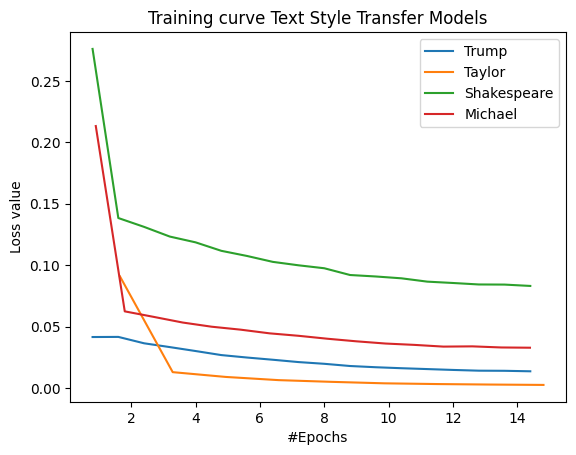

In [ ]:
#Plotting of different curves on a graph 
plt.plot(list_df[0]['epoch_number'].values, list_df[0]['loss'].values, label = 'Trump') 
plt.plot(list_df[1]['epoch_number'].values, list_df[1]['loss'].values, label = 'Taylor') 
plt.plot(list_df[2]['epoch_number'].values, list_df[2]['loss'].values, label = 'Shakespeare') 
plt.plot(list_df[3]['epoch_number'].values, list_df[3]['loss'].values, label = 'Michael') 
plt.xlabel('#Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.title('Training curve Text Style Transfer Models')

##Test for TST on Recipes

Using the Recipe dataset created using the recipes generated by the FT DistilGPT2 model, for the style transfer. **Takes entire recipe as an input**

In [ ]:
#Loading the recipes 
df = pd.read_csv('/content/drive/MyDrive/685 Project/TST_Recipe_Inputs_and_Generations')

In [ ]:
df.head()

,M_Input,M_Output,TST_Input,TST_Iput_ids,TST_Input_ids
0,"Ingredients: [fresh strawberries, strawberry J...","Ingredients: [fresh strawberries, strawberry J...",Input: Hull berries and chop coarsely; set asi...,"[[tensor(86), tensor(2562), tensor(10), tensor...","[[tensor(86), tensor(2562), tensor(10), tensor..."
1,Ingredients: ['1 small butternut squash (about...,Ingredients: ['1 small butternut squash (about...,Input: Preheat oven to 400°F. Place squash on ...,"[[tensor(86), tensor(2562), tensor(10), tensor...","[[tensor(86), tensor(2562), tensor(10), tensor..."
2,"Ingredients: [margarine, sugar, egg, milk, sal...","Ingredients: [margarine, sugar, egg, milk, sal...",Input: Cream margarine and sugar until light. ...,"[[tensor(86), tensor(2562), tensor(10), tensor...","[[tensor(86), tensor(2562), tensor(10), tensor..."
3,"Ingredients: [dinner rolls, brown sugar, regul...","Ingredients: [dinner rolls, brown sugar, regul...",Input: Butter a Bundt pan and place frozen rol...,"[[tensor(86), tensor(2562), tensor(10), tensor...","[[tensor(86), tensor(2562), tensor(10), tensor..."
4,"Ingredients: [apple, lemon juice, trout] Recipe:","Ingredients: [apple, lemon juice, trout] Recip...",Input: Place the diced apple in a small sieve ...,"[[tensor(86), tensor(2562), tensor(10), tensor...","[[tensor(86), tensor(2562), tensor(10), tensor..."


In [ ]:
#Extraction of the Input to the TST model - Recipes generated (Do not need the Ingredients)
def get_generated_recipe(x):
  x = str(x)
  input = ' '.join(x.split()[x.split().index('Recipe:')+1 : ])
  input = ' '.join(["Input:",input])
  return input

In [ ]:
df['TST_Input'] = df['M_Output'].apply(get_generated_recipe)

In [ ]:
# Loading of the FT TST model()
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
filename = "Michael"
base_tokenizer = AutoTokenizer.from_pretrained('t5-base')
base_model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/drive/MyDrive/685 Project/{filename}_TST/{filename}_TST_Model")

In [ ]:
#Performing the Text Style Transfer using the FT TST model on the generated recipes 
tst_generation = []
for idx,row in df.iterrows():

  input = df['TST_Input'].iloc[idx]
  input = base_tokenizer(input, return_tensors="pt").input_ids

  #For different decoding strategies
  do_sample = False
  num_beams = 1 
  top_p = 1.0

  output = base_model.generate(input, num_beams=num_beams, do_sample=do_sample, top_p = top_p, min_length=len(input[0]), max_length=1024)
  # print(base_tokenizer.batch_decode(output, skip_special_tokens=True)[0][7:])
  tst_generation.append(base_tokenizer.batch_decode(output, skip_special_tokens=True)[0][7:])

In [ ]:
final_tst_generations = []

In [ ]:
#Storing all the generations in a list
final_tst_generations = final_tst_generations + tst_generation

In [ ]:
#Adding all the styles recipes in the Dataframe
df['TST_Output'] = final_tst_generations

In [ ]:
#Dropping irrelevant information 
df.drop(['M_Input', 'M_Output'],axis=1, inplace=True)

In [ ]:
df.to_csv('/content/drive/MyDrive/685 Project/Styled_Recipes', index=True)

##Sentence-wise TST

In this section, the recipes are divided into separate instructions. Then the Text Style Transfer is applied on the instructions individually, and lastly, all the instructions are concatenated into a single styled recipe 

In [ ]:
#Loading the recipes generated by FT DistilGPT2
df = pd.read_csv('/content/drive/MyDrive/685 Project/TST_Recipe_Inputs_and_Generations')

In [ ]:
#Extracting the Recipe generated
def get_generated_recipe(x):
  x = str(x)
  input = x.split('.')
  input = ' '.join(x.split()[x.split().index('Recipe:')+1 : ])
  return input

In [ ]:
df['TST_Input'] = df['M_Output'].apply(get_generated_recipe)

In [ ]:
#Loading of FT TST model and the tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
filename = "Michael"
base_tokenizer = AutoTokenizer.from_pretrained('t5-base')
base_model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/drive/MyDrive/685 Project/{filename}_TST/{filename}_TST_Model")

In [ ]:
#Performing sentence wise Text Style Transfer 
tst_generation = []
for idx,row in df.iterrows():
  if idx<150:
    continue
  input = df['TST_Input'].iloc[idx]
  final_outs = []
  for sent in input.split('.'):
    sentence = "Input: " + sent
    sentence = base_tokenizer(sentence, return_tensors="pt").input_ids

    #For different decoding strategies
    do_sample = False
    num_beams = 1 
    top_p = 1

    output = base_model.generate(sentence, num_beams=num_beams, do_sample=do_sample, top_p = top_p,min_length = len(input[0]), max_length=1024)
    final_outs.append(base_tokenizer.batch_decode(output, skip_special_tokens=True)[0][7:])

  full_recipe = ' '.join(final_outs)
  tst_generation.append(full_recipe[1:])

In [ ]:
final_tst_generations = []

In [ ]:
#Appended all the recipes into a single list
final_tst_generations = final_tst_generations + tst_generation

In [ ]:
#Included the styles recipes in the dataframe
df['TST_Output'] = final_tst_generations

In [ ]:
df.drop(['M_Input', 'M_Output'],axis=1, inplace=True)

In [ ]:
df.to_excel('/content/drive/MyDrive/685 Project/Sentence_Styled_Recipes.xlsx')

##Random Sentence TST Test

Check how the FT TST models perform on random sentences

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
filename = "Shakespeare"
base_tokenizer = AutoTokenizer.from_pretrained('t5-base')
base_model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/drive/MyDrive/685 Project/{filename}_TST/{filename}_TST_Model")

In [ ]:
input = "To all of those who have asked, I will not be going to the Inaugration on January 20th."
input = "Input: " + input
input = base_tokenizer(input, return_tensors="pt").input_ids

#For different decoding strategies
do_sample = False
num_beams = 1 
top_p = 0.9

output = base_model.generate(input, num_beams=num_beams, do_sample=do_sample, top_p = top_p,min_length = len(input[0]), max_length=1024)
print(base_tokenizer.batch_decode(output, skip_special_tokens=True))

['Output: cook rice and set aside in a nonstick frying pan, add olive oil and heat until almost smoking. Add chicken and sea salt and cook for 2-3 minutes (scrambled). Add rice and stir up; add soy sauce and seasonings and/or crushed red pepper. Serve hot (speas 4-6 servings). Serve hot (speas 3.5.8). Serve hot (speas 3.5.7). Serves hot (s complaints o):.) and) in a-styled cooking pan']
